<!-- Jane Street Real-Time Market Data Forecasting -->
<a id="0"></a>
<div style="font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#FF6B6B; font-size:300%; text-align:left; padding:3.0px; background: #2B303A; border-bottom: 8px solid #36454F">
    Jane Street Real-Time Market Data Forecasting<br>
</div>

# Introduction

This competition challenges participants to build models using real-world financial data derived from Jane Street's production systems.

- **Anonymized and obfuscated features**: The data represents real trading systems but is anonymized to protect proprietary information.
- **Non-stationary time series**: Participants must deal with evolving data that doesn't follow traditional assumptions, making modeling more difficult.
- **Fat-tailed distributions**: Extreme events and outliers are common, requiring robust models that can handle unpredictable outcomes.
- **Submission guidelines**: Models must be trained using **Kaggle Notebooks**, with a time limit of **8 hours** for both CPU and GPU during the training phase.
- **Forecasting phase**: After the final submission, models will be tested on real market data, with an extended **9-hour runtime** during this phase.

# Automated EDA

In [1]:
!pip install autogluon.tabular  > /dev/null 2>&1
!pip install -U ipywidgets  > /dev/null 2>&1
!pip install sweetviz > /dev/null 2>&1
!pip install langchain-core > /dev/null 2>&1
!pip install langchain-openai  > /dev/null 2>&1

In [2]:
# Import libraries

# General Purpose Libraries
import os
from pathlib import Path
import json
import logging
import numpy as np
import polars as pl
import pandas as pd
import sweetviz as sv
import seaborn as sns
import pprint
import matplotlib.pyplot as plt
from itertools import product
import warnings
from IPython.display import Markdown, display
from kaggle_secrets import UserSecretsClient
from scipy.stats import ttest_ind, stats

# LLM Libraries
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

# Suppress specific FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# Secrets Management
user_secrets = UserSecretsClient()
OPENAI_API_KEY = user_secrets.get_secret("openai_key")

In [4]:
# Define the LLM model using LangChain
model = ChatOpenAI(
    model='gpt-4o-2024-05-13',
    temperature=0,
    api_key=OPENAI_API_KEY
)

In [5]:
# Helper functions

# Function to classify columns into continuous and categorical
def classify_columns(df):
    continuous_cols = []
    categorical_cols = []
    for column in df.columns:
        if df[column].dtypes == 'object':
            categorical_cols.append(column)
        else:
            unique_values = df[column].nunique()
            if unique_values < 15:
                categorical_cols.append(column)
            else:
                continuous_cols.append(column)
    return continuous_cols, categorical_cols

# Function to perform basic visualizations for continuous and categorical features
def eda_visualizations(df, target=None):
    continuous_cols, categorical_cols = classify_columns(df)
    
    # Plotting continuous columns
    for col in continuous_cols:
        plt.figure(figsize=(10, 4))
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()
    
    # Plotting categorical columns
    for col in categorical_cols:
        plt.figure(figsize=(10, 4))
        sns.countplot(data=df, x=col, hue=target)
        plt.title(f'Count plot for {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()

# Function to compare train and test datasets
def compare_train_test(train, test):
    continuous_cols, categorical_cols = classify_columns(train)
    
    # Compare continuous columns
    for col in continuous_cols:
        plt.figure(figsize=(10, 4))
        sns.kdeplot(train[col], label='Train', shade=True)
        sns.kdeplot(test[col], label='Test', shade=True)
        plt.title(f'Comparison of {col} Distribution in Train vs Test')
        plt.xlabel(col)
        plt.ylabel('Density')
        plt.legend()
        plt.show()
    
    # Compare categorical columns
    for col in categorical_cols:
        if col in test.columns:  # Ensure the column exists in the test dataset
            plt.figure(figsize=(10, 4))
            train_counts = train[col].value_counts(normalize=True)
            test_counts = test[col].value_counts(normalize=True)
            train_counts.plot(kind='bar', alpha=0.5, label='Train', color='blue')
            test_counts.plot(kind='bar', alpha=0.5, label='Test', color='red')
            plt.title(f'Comparison of {col} Proportions in Train vs Test')
            plt.xlabel(col)
            plt.ylabel('Proportion')
            plt.legend()
            plt.xticks(rotation=45)
            plt.show()
            
# Function to create key statistics for a dataset
def eda_summary(df):
    summary = {}
    
    # General Info
    summary['general'] = {
        'num_rows': df.shape[0],
        'num_columns': df.shape[1],
        'num_missing_values': df.isnull().sum().sum(),
        'percent_missing_values': df.isnull().mean().mean() * 100
    }
    
    # Column Data Types
    summary['data_types'] = df.dtypes.to_dict()
    
    # Missing Value Summary (per column)
    summary['missing_values'] = (
        df.isnull()
        .sum()
        .to_frame(name='missing_count')
        .assign(percent_missing=lambda x: (x['missing_count'] / df.shape[0]) * 100)
        .to_dict(orient='index')
    )
    
    # Numerical Summary (Mean, Median, Std, Min, Max)
    describe_df = df.describe()
    numerical_columns = ['mean', '50%', 'std', 'min', 'max']
    available_columns = [col for col in numerical_columns if col in describe_df.columns]
    summary['numerical_summary'] = (
        describe_df[available_columns]
        .rename(columns={'50%': 'median'})
        .to_dict(orient='index')
    )
    
    # Unique Counts for Categorical Columns
    summary['categorical_summary'] = (
        df.select_dtypes(include=['object', 'category'])
        .nunique()
        .to_frame(name='unique_counts')
        .to_dict(orient='index')
    )
    
    # Skewness and Kurtosis
    summary['skewness_kurtosis'] = {
        column: {
            'skewness': df[column].skew(),
            'kurtosis': df[column].kurt()
        } for column in df.select_dtypes(include=[np.number]).columns
    }
    
    # Correlations
    try:
        summary['correlations'] = df.corr(numeric_only=True).to_dict()
    except ValueError:
        summary['correlations'] = "Unable to calculate correlations due to data type issues."
    
    # Outlier Count based on IQR
    outlier_summary = {}
    for column in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]
        outlier_summary[column] = {
            'outlier_count': outliers.shape[0],
            'percent_outliers': (outliers.shape[0] / df.shape[0]) * 100
        }
    summary['outlier_summary'] = outlier_summary

    return summary

# Function to create a summarized key statistics for a dataset
# Function to create a summarized key statistics for a dataset
def eda_summary_concise(df):
    summary = {}
    
    # General Info
    summary['general'] = {
        'num_rows': df.shape[0],
        'num_columns': df.shape[1],
        'percent_missing_values': df.isnull().mean().mean() * 100
    }
    
    # Column Data Types Summary
    data_types = df.dtypes.apply(lambda x: str(x)).value_counts().to_dict()
    summary['data_types_summary'] = data_types
    
    # Columns with the Most Missing Values
    missing_values = (
        df.isnull().sum()
        .sort_values(ascending=False)
        .head(5)  # Limit to top 5 columns
        .to_frame(name='missing_count')
        .assign(percent_missing=lambda x: (x['missing_count'] / df.shape[0]) * 100)
        .to_dict(orient='index')
    )
    # Converting any non-serializable keys to strings
    missing_values = {str(k): v for k, v in missing_values.items()}
    summary['most_missing_values'] = missing_values

    # Key Numerical Summary (Mean, Median, Std)
    describe_df = df.describe()
    numerical_summary = describe_df.loc[['mean', '50%', 'std']].to_dict(orient='index')
    numerical_summary = {str(k): v for k, v in numerical_summary.items()}
    summary['numerical_summary'] = numerical_summary
    
    # Correlations Summary (only highest correlations)
    correlations = df.corr(numeric_only=True)
    if correlations is not None:
        highest_corrs = (
            correlations.unstack()
            .sort_values(key=lambda x: abs(x), ascending=False)
            .drop_duplicates()
            .head(5)
            .to_dict()
        )
        # Converting the keys which are tuples into strings
        highest_corrs = {f"{k[0]}_{k[1]}": v for k, v in highest_corrs.items()}
        summary['highest_correlations'] = highest_corrs

    return summary

In [6]:
# load datasets
DATA_DIR = "/kaggle/input/jane-street-real-time-market-data-forecasting"

features = pd.read_csv(f"{DATA_DIR}/features.csv")
responders = pd.read_csv(f"{DATA_DIR}/responders.csv")

In [7]:
# training set

dir_path = Path(DATA_DIR, 'train.parquet/')

for file in dir_path.glob('*'):
    print(file)

/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=4
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=5
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=6
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=3
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=1
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=8
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=2
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=0
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=7
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=9


In [8]:
train = pl.read_parquet(f"{DATA_DIR}/train.parquet/partition_id=0/part-0.parquet")

In [9]:
train_pd = train.to_pandas()

In [10]:
# Automated EDA report with sweetviz
report = sv.analyze(train_pd, pairwise_analysis="off")
report.show_html(filepath='/kaggle/working/train_data_report.html', open_browser=False)

                                             |          | [  0%]   00:00 -> (? left)

Report /kaggle/working/train_data_report.html was generated.


In [11]:
# Assuming train_pd is the DataFrame
summary_concise = eda_summary_concise(train_pd)

# Serializing to JSON
summary_json_concise = json.dumps(summary_concise, indent=4, default=str)

In [12]:
template = """Provide an analysis of the following EDA summary:
{context}

Key insights and observations:
"""

prompt = ChatPromptTemplate.from_template(template)

# Create a chain to pass the summary to the model
chain = prompt | model | StrOutputParser()

# Invoke the chain to analyze the EDA summary
result = chain.invoke(summary_json_concise)

# Print the result
display(Markdown(result))

The provided Exploratory Data Analysis (EDA) summary offers a comprehensive overview of a dataset with 1,944,210 rows and 92 columns. Here are the key insights and observations:

### General Overview
1. **Size and Structure**:
   - The dataset is quite large, with nearly 2 million rows and 92 columns.
   - The dataset has a significant amount of missing data, with approximately 11.41% of the values missing.

### Data Types Summary
2. **Data Types**:
   - The majority of the columns are of type `float32` (86 columns).
   - There are a few integer columns: 3 of type `int16` and 3 of type `int8`.

### Missing Values
3. **Most Missing Values**:
   - Five features (`feature_27`, `feature_21`, `feature_31`, `feature_00`, and `feature_01`) have 100% missing values. This means these columns do not contain any data and might need to be dropped or imputed if they are essential.
   - The high percentage of missing values in these features significantly contributes to the overall missing value percentage.

### Numerical Summary
4. **Descriptive Statistics**:
   - **Mean**: The mean values for most features are close to zero, indicating that the data might be centered around zero.
   - **Median (50%)**: The median values for many features are also close to zero, suggesting a symmetric distribution around zero for these features.
   - **Standard Deviation (std)**: The standard deviation varies significantly across features, indicating varying levels of dispersion. For example, `feature_62`, `feature_63`, and `feature_64` have high standard deviations, suggesting high variability in these features.
   - **NaN Values**: Several features have NaN values for mean, median, and standard deviation, which aligns with the missing values summary.

### Correlations
5. **Highest Correlations**:
   - The highest correlations are observed between:
     - `feature_75` and `feature_76` (0.959)
     - `feature_77` and `feature_78` (0.957)
     - `feature_73` and `feature_74` (0.956)
     - `feature_43` and `feature_40` (0.949)
   - These high correlations suggest that these pairs of features are highly linearly related and might contain redundant information.

### Key Insights and Observations
1. **Data Cleaning**:
   - The features with 100% missing values (`feature_27`, `feature_21`, `feature_31`, `feature_00`, and `feature_01`) should be considered for removal unless they are critical and can be imputed meaningfully.
   - The overall missing value percentage (11.41%) is significant and needs to be addressed through imputation or removal of rows/columns with missing values.

2. **Feature Engineering**:
   - The high correlations between certain features suggest potential redundancy. Dimensionality reduction techniques like PCA or feature selection methods could be applied to reduce the feature space without losing much information.

3. **Data Distribution**:
   - The mean and median values being close to zero for many features suggest that the data might be centered and possibly normalized. However, the varying standard deviations indicate different scales, which might require standardization before applying machine learning models.

4. **Variability**:
   - Features with high standard deviations (`feature_62`, `feature_63`, `feature_64`) indicate high variability, which could be important for predictive modeling but might also require careful handling to avoid overfitting.

5. **Further Analysis**:
   - Additional analysis might be needed to understand the relationships between features and the target variable (if any) to identify the most predictive features.
   - Investigating the distribution and outliers in the features with high variability could provide more insights into the data quality and necessary preprocessing steps.

In summary, the dataset is large and complex, with significant missing values and varying levels of feature variability. Addressing missing values, handling highly correlated features, and standardizing the data are crucial steps before proceeding with any modeling efforts.

# Detailled EDA

In [13]:
# General Overview
def general_overview(data):
    print("\n--- General Overview ---\n")
    print(f"Dataset Shape: {data.shape}")
    print(f"Dataset Info:\n{data.info()}")
    print(f"Dataset Missing Values:\n{data.isnull().sum()}")
    print(f"Dataset Missing Values Percentage:\n{data.isnull().sum() / len(data) * 100}")
    print("\n")

# Data Types Summary
def data_types_summary(data):
    print("--- Data Types Summary ---\n")
    print(data.dtypes.value_counts())
    print("\n")

# Check Missing Values
def missing_values_summary(data):
    print("--- Missing Values ---\n")
    missing_values = data.isnull().sum().sort_values(ascending=False)
    missing_percent = (missing_values / len(data)) * 100
    missing_summary = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percent})
    print(missing_summary[missing_summary['Missing Values'] > 0])
    print("\n")

# Descriptive Statistics
def descriptive_statistics(data):
    print("--- Descriptive Statistics ---\n")
    desc_stats = data.describe(include='all')
    print(desc_stats)
    print("\n")

# Correlation Analysis
def correlation_analysis(data, threshold=0.9):
    print("--- Correlation Analysis ---\n")
    correlations = data.corr()
    sns.heatmap(correlations, cmap="coolwarm", linewidths=0.5)
    plt.title("Correlation Heatmap")
    plt.show()

    # Display high correlation pairs
    high_corr_pairs = []
    for i in range(correlations.shape[0]):
        for j in range(i + 1, correlations.shape[0]):
            if abs(correlations.iloc[i, j]) > threshold:
                high_corr_pairs.append((correlations.columns[i], correlations.columns[j], correlations.iloc[i, j]))

    if high_corr_pairs:
        print("High correlation pairs (>0.9):")
        for feature1, feature2, corr_value in high_corr_pairs:
            print(f"{feature1} and {feature2}: {corr_value:.2f}")
    else:
        print("No highly correlated feature pairs found (>0.9)")
    print("\n")

# Missing Values Handling
def visualize_missing_data(data):
    print("--- Visualizing Missing Data ---\n")
    plt.figure(figsize=(12, 6))
    sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
    plt.title('Heatmap of Missing Data')
    plt.show()

# Visualizing Selected Feature Relationships
def visualize_feature_relationships(data, features):
    for feature in features:
        plt.figure(figsize=(10, 5))
        sns.histplot(data[feature].dropna(), kde=True)
        plt.title(f'Distribution of {feature}')
        plt.xlabel(feature)
        plt.ylabel('Count')
        plt.show()

In [14]:
# Running the EDA
general_overview(train_pd)


--- General Overview ---

Dataset Shape: (1944210, 92)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1944210 entries, 0 to 1944209
Data columns (total 92 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date_id      int16  
 1   time_id      int16  
 2   symbol_id    int8   
 3   weight       float32
 4   feature_00   float32
 5   feature_01   float32
 6   feature_02   float32
 7   feature_03   float32
 8   feature_04   float32
 9   feature_05   float32
 10  feature_06   float32
 11  feature_07   float32
 12  feature_08   float32
 13  feature_09   int8   
 14  feature_10   int8   
 15  feature_11   int16  
 16  feature_12   float32
 17  feature_13   float32
 18  feature_14   float32
 19  feature_15   float32
 20  feature_16   float32
 21  feature_17   float32
 22  feature_18   float32
 23  feature_19   float32
 24  feature_20   float32
 25  feature_21   float32
 26  feature_22   float32
 27  feature_23   float32
 28  feature_24   float32
 29  feature_25   float32

In [15]:
data_types_summary(train_pd)

--- Data Types Summary ---

float32    86
int16       3
int8        3
Name: count, dtype: int64




In [16]:
missing_values_summary(train_pd)

--- Missing Values ---

            Missing Values  Percentage
feature_27         1944210  100.000000
feature_21         1944210  100.000000
feature_31         1944210  100.000000
feature_00         1944210  100.000000
feature_01         1944210  100.000000
feature_02         1944210  100.000000
feature_03         1944210  100.000000
feature_04         1944210  100.000000
feature_26         1944210  100.000000
feature_39          324732   16.702517
feature_42          324732   16.702517
feature_53          293120   15.076561
feature_50          293120   15.076561
feature_66          166374    8.557409
feature_65          166374    8.557409
feature_46          166374    8.557409
feature_45          166374    8.557409
feature_62          153999    7.920904
feature_64          136458    7.018686
feature_63          133274    6.854918
feature_41           97113    4.994985
feature_44           97113    4.994985
feature_52           64120    3.297998
feature_55           64120    3.297998
f

In [17]:
descriptive_statistics(train_pd)

--- Descriptive Statistics ---

            date_id       time_id     symbol_id        weight  feature_00  \
count  1.944210e+06  1.944210e+06  1.944210e+06  1.944210e+06         0.0   
mean   9.384629e+01  4.240000e+02  1.376638e+01  1.973281e+00         NaN   
std    4.813196e+01  2.450851e+02  1.108778e+01  9.691969e-01         NaN   
min    0.000000e+00  0.000000e+00  0.000000e+00  4.405696e-01         NaN   
25%    5.400000e+01  2.120000e+02  7.000000e+00  1.323803e+00         NaN   
50%    9.900000e+01  4.240000e+02  1.200000e+01  1.763827e+00         NaN   
75%    1.360000e+02  6.360000e+02  1.700000e+01  2.393846e+00         NaN   
max    1.690000e+02  8.480000e+02  3.800000e+01  6.011999e+00         NaN   

       feature_01  feature_02  feature_03  feature_04    feature_05  ...  \
count         0.0         0.0         0.0         0.0  1.944210e+06  ...   
mean          NaN         NaN         NaN         NaN -4.463175e-02  ...   
std           NaN         NaN         NaN     

--- Correlation Analysis ---



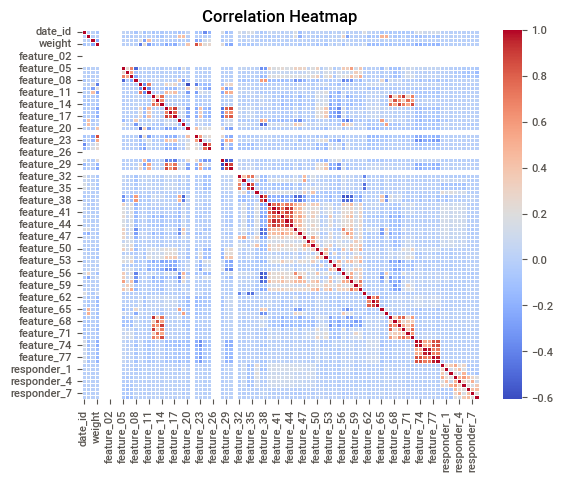

High correlation pairs (>0.9):
feature_12 and feature_67: 0.93
feature_12 and feature_70: 0.91
feature_15 and feature_17: 0.90
feature_40 and feature_41: 0.91
feature_40 and feature_43: 0.95
feature_43 and feature_44: 0.91
feature_73 and feature_74: 0.96
feature_75 and feature_76: 0.96
feature_77 and feature_78: 0.96




In [18]:
correlation_analysis(train_pd)

--- Visualizing Missing Data ---



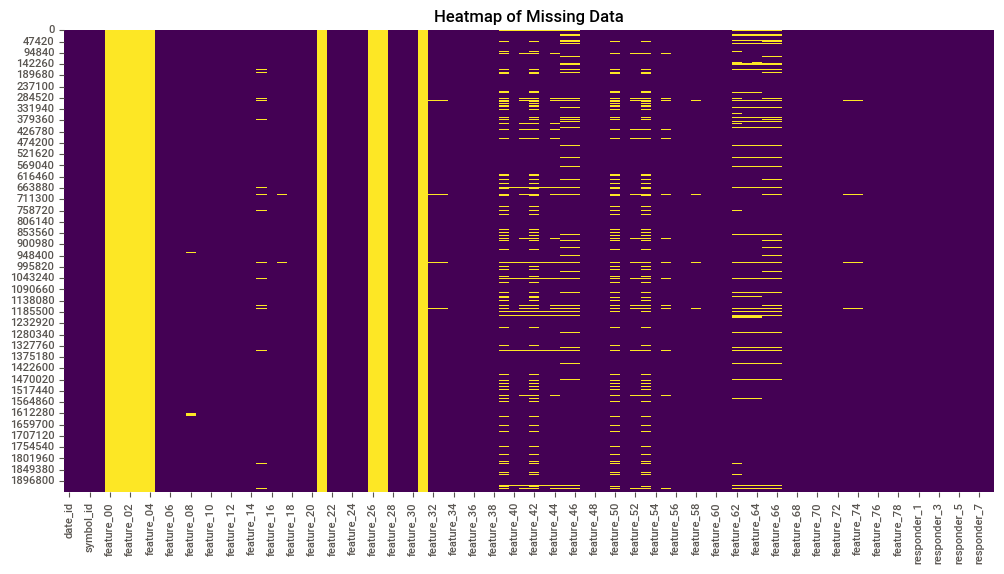

In [19]:
visualize_missing_data(train_pd)

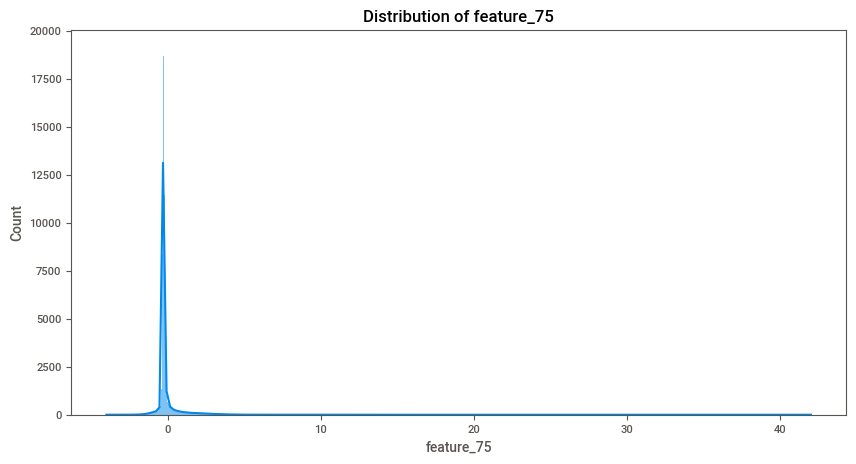

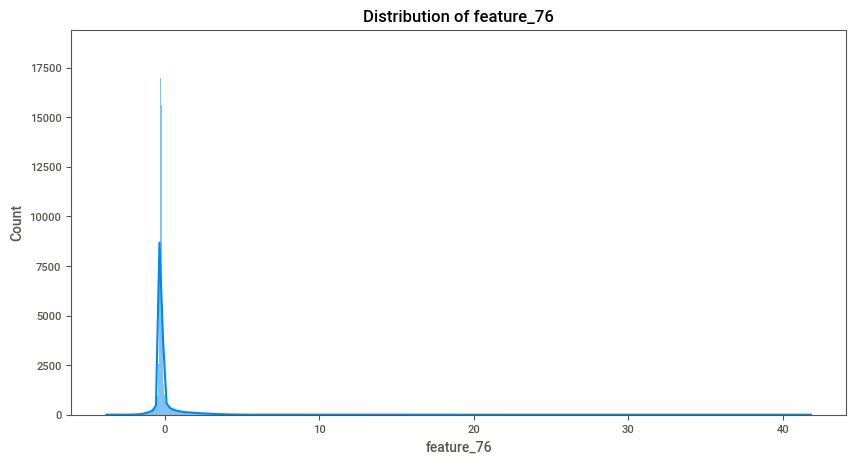

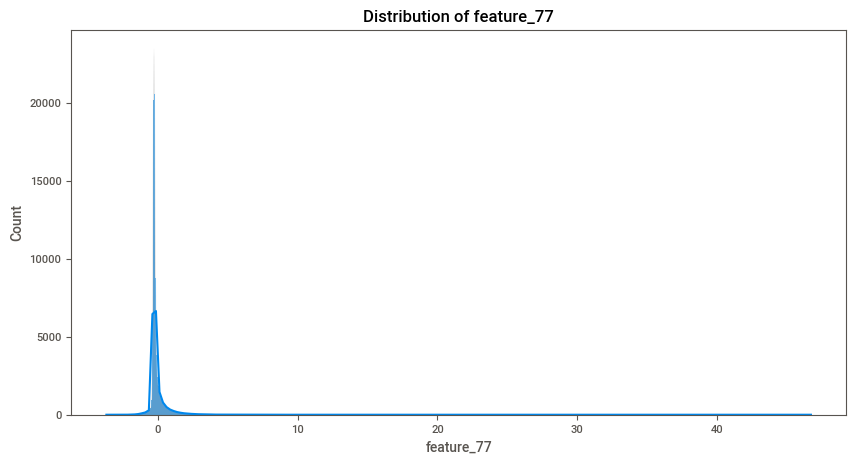

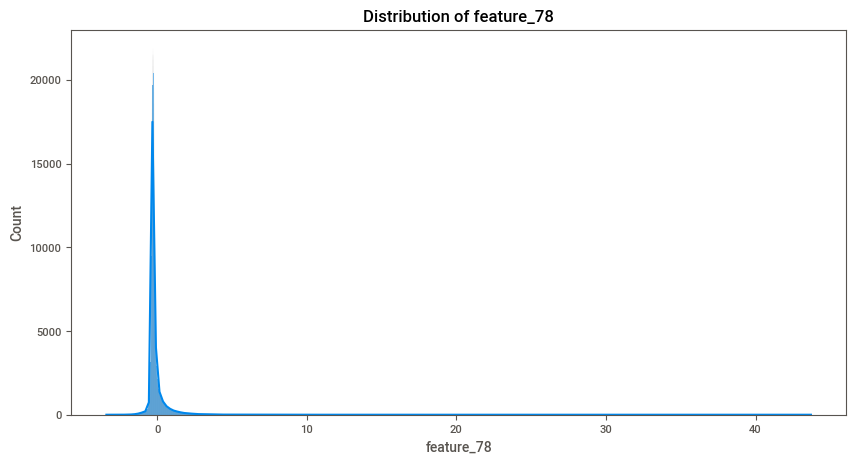

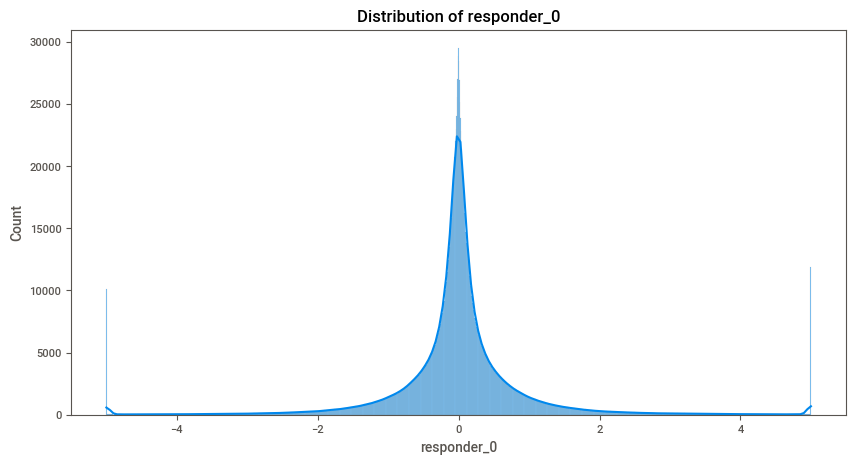

In [20]:
# Visualize key feature relationships
selected_features = ['feature_75', 'feature_76', 'feature_77', 'feature_78', 'responder_0']
visualize_feature_relationships(train_pd, selected_features)

In [21]:
# Plotting Feature by Time
def plot_feature_by_time(data, feature, time_column='time_id'):
    print(f"--- Plotting {feature} by {time_column} ---\n")
    plt.figure(figsize=(14, 7))
    plt.plot(data[time_column], data[feature], marker='o', linestyle='-', alpha=0.7)
    plt.xlabel(time_column)
    plt.ylabel(feature)
    plt.title(f'{feature} Over {time_column}')
    plt.grid(True)
    plt.show()

# Analyzing Symbol Distribution
def analyze_symbol_distribution(data):
    print("--- Analyzing Symbol Distribution ---\n")
    symbol_counts = data['symbol_id'].value_counts()
    print(f"Number of Unique Symbols: {symbol_counts.count()}")
    plt.figure(figsize=(14, 7))
    sns.histplot(symbol_counts, bins=50, kde=True)
    plt.title('Distribution of Symbols (symbol_id)')
    plt.xlabel('Symbol Count')
    plt.ylabel('Frequency')
    plt.show()

# Analyzing Weight Distribution
def analyze_weight_distribution(data):
    print("--- Analyzing Weight Distribution ---\n")
    plt.figure(figsize=(10, 5))
    sns.histplot(data['weight'].dropna(), kde=True)
    plt.title('Distribution of Weight')
    plt.xlabel('Weight')
    plt.ylabel('Count')
    plt.show()

# Analyzing Responder Target (responder_6)
def analyze_responder_target(data):
    print("--- Analyzing Responder Target (responder_6) ---\n")
    plt.figure(figsize=(10, 5))
    sns.histplot(data['responder_6'].dropna(), kde=True)
    plt.title('Distribution of responder_6 (Target)')
    plt.xlabel('Responder 6')
    plt.ylabel('Count')
    plt.show()

--- Plotting feature_75 by time_id ---



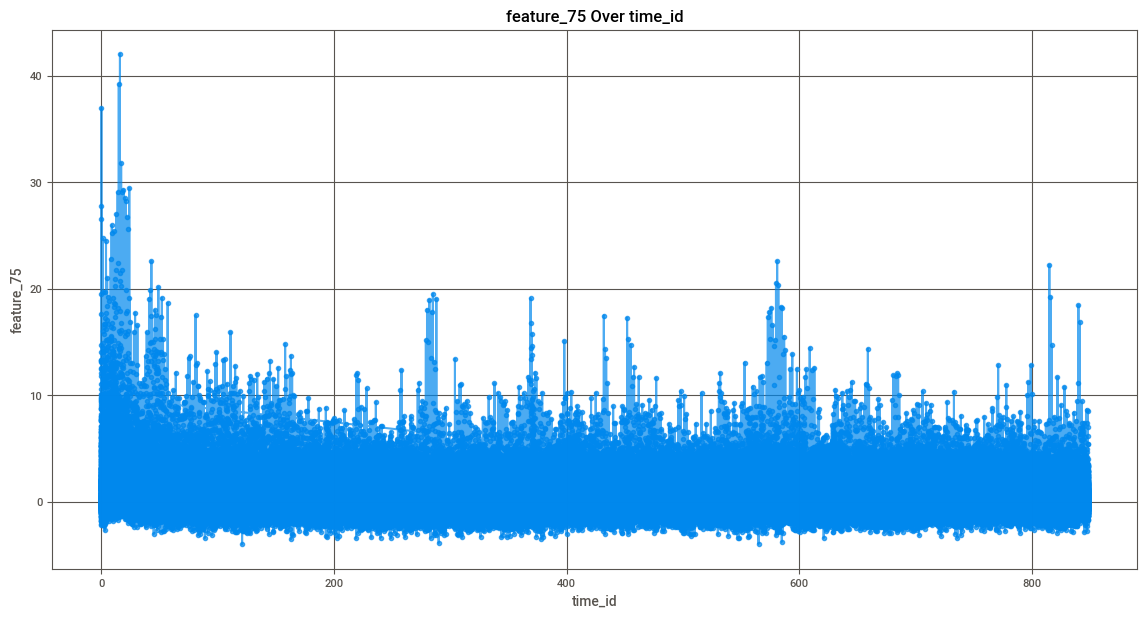

In [22]:
# Plotting feature by time
time_column = 'time_id'
plot_feature_by_time(train_pd, 'feature_75', time_column)

--- Plotting feature_72 by time_id ---



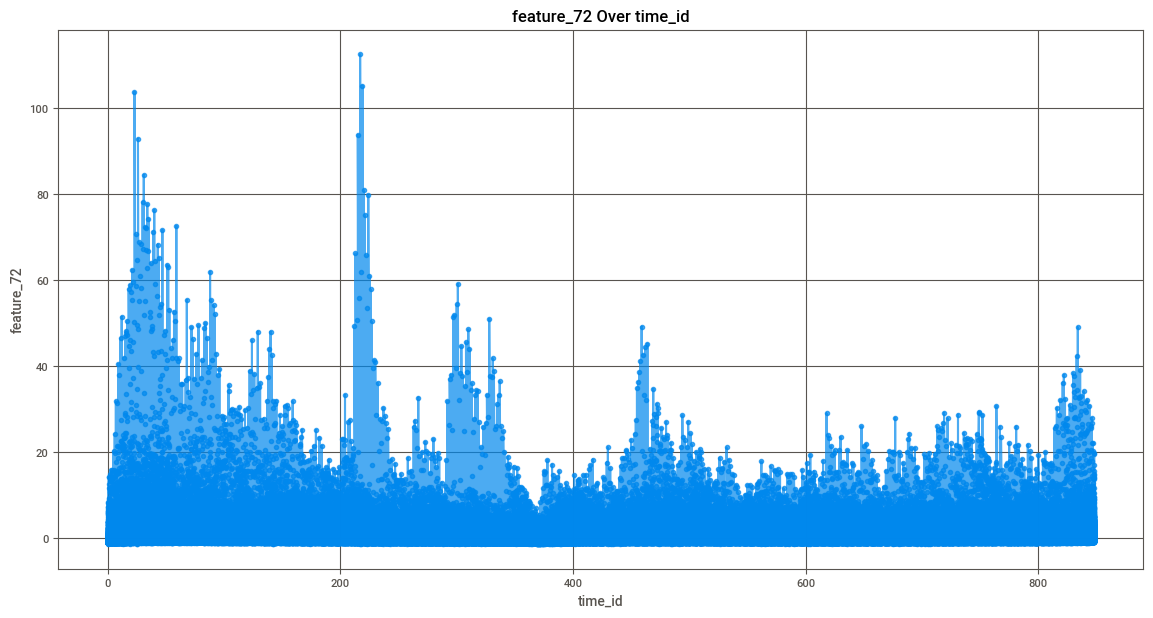

In [23]:
time_column = 'time_id'
plot_feature_by_time(train_pd, 'feature_72', time_column)

--- Analyzing Symbol Distribution ---

Number of Unique Symbols: 20


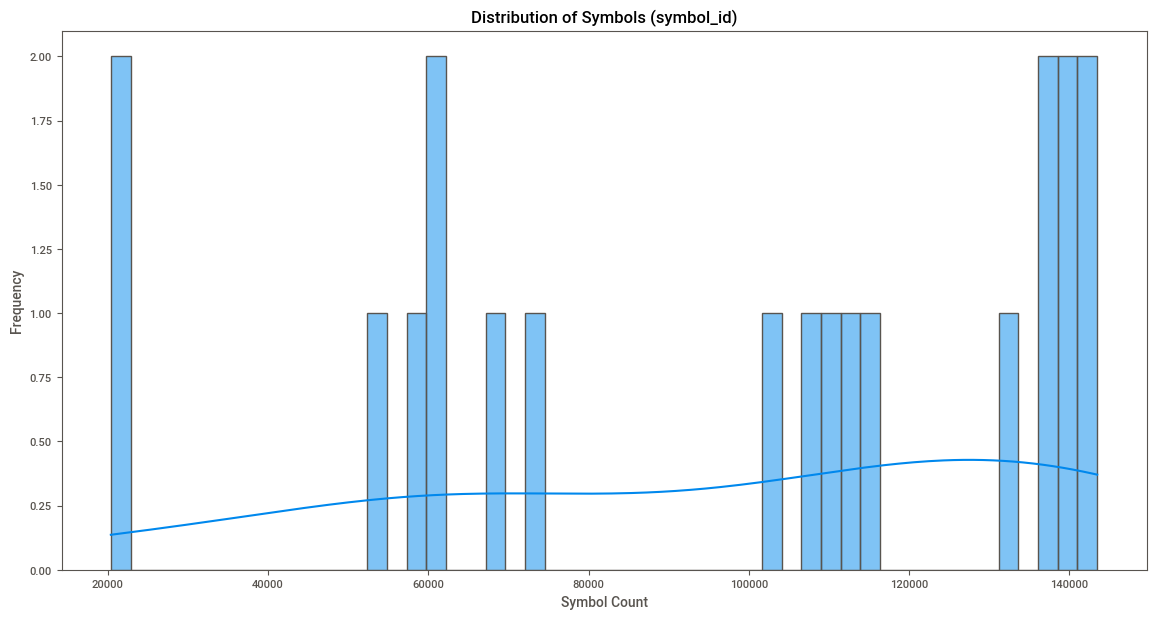

In [24]:
# Analyze Symbol Distribution
analyze_symbol_distribution(train_pd)

--- Analyzing Weight Distribution ---



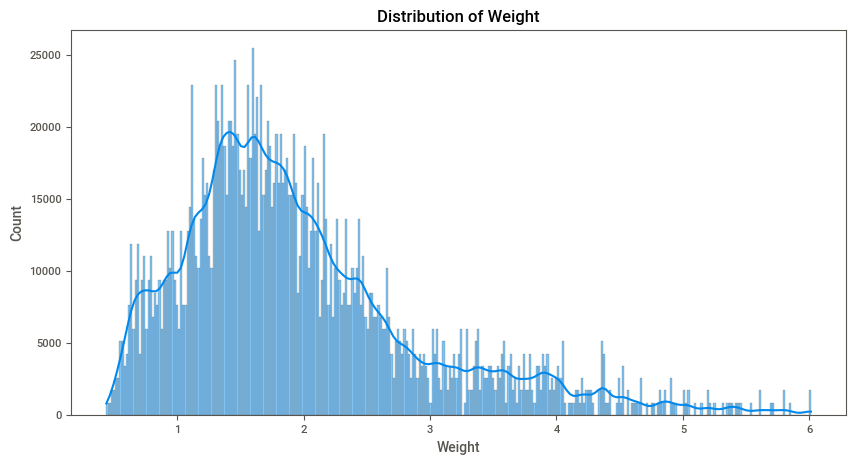

In [25]:
# Analyze Weight Distribution
analyze_weight_distribution(train_pd)

--- Analyzing Responder Target (responder_6) ---



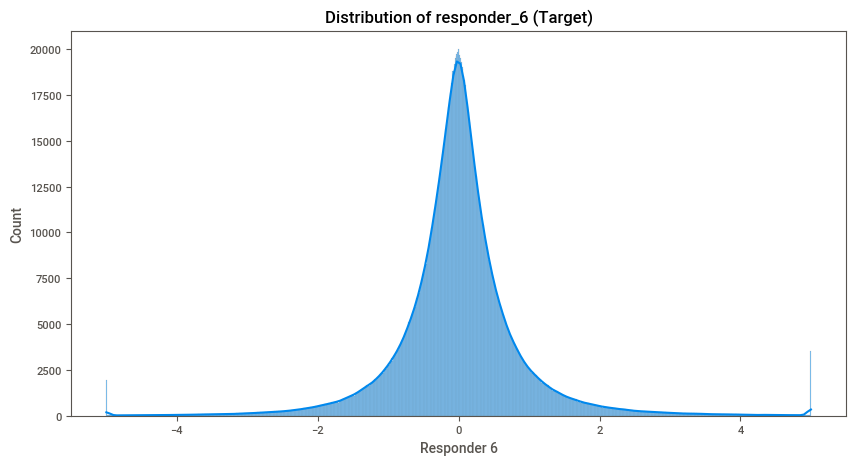

In [26]:
# Analyze Responder Target (responder_6)
analyze_responder_target(train_pd)

In [27]:
# Plotting Feature for a Given Symbol
def plot_feature_for_symbol(data, feature, symbol_id, time_column='time_id'):
    print(f"--- Plotting {feature} for Symbol {symbol_id} by {time_column} ---\n")
    symbol_data = data[data['symbol_id'] == symbol_id].sort_values(by=[time_column])
    if symbol_data.empty:
        print(f"No data available for symbol_id {symbol_id}")
    else:
        plt.figure(figsize=(14, 7))
        plt.plot(symbol_data[time_column], symbol_data[feature], marker='o', linestyle='-', alpha=0.7)
        plt.xlabel(time_column)
        plt.ylabel(feature)
        plt.title(f'{feature} for Symbol {symbol_id} Over {time_column}')
        plt.grid(True)
        plt.show()

--- Plotting feature_72 for Symbol 2 by time_id ---



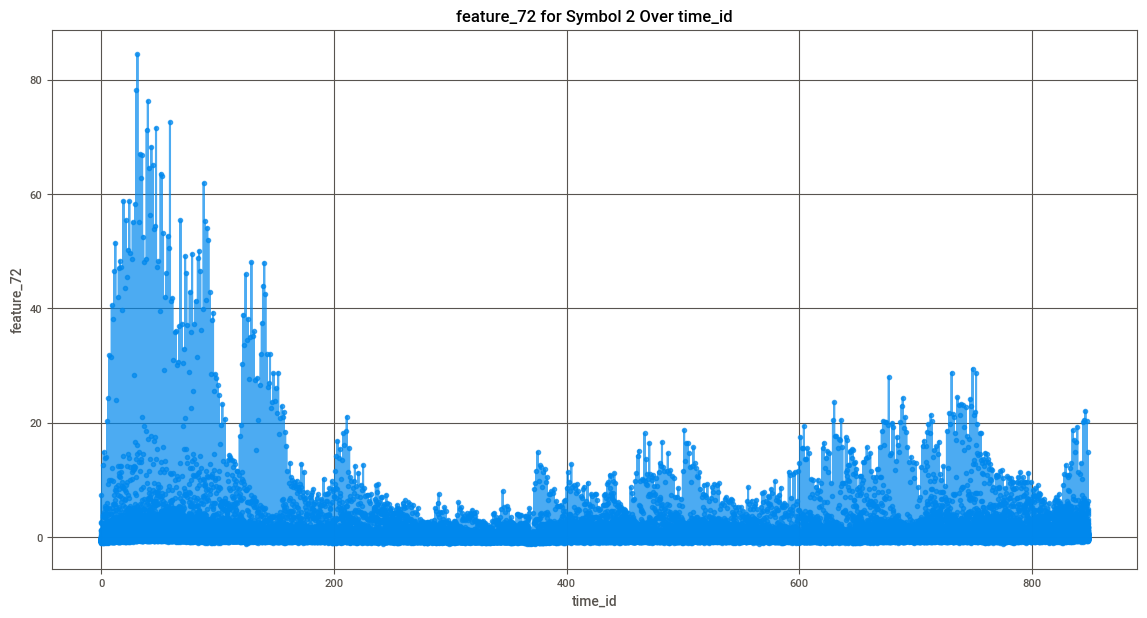

In [28]:
# Plotting feature_75 for a given symbol (example with symbol_id=5)
plot_feature_for_symbol(train_pd, 'feature_72', symbol_id=2, time_column='time_id')